In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Shruti@1104',
    database='ecomm'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/BIT/Desktop/Ecommerce'
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]
    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Shruti@1104",
                             database = "ecomm")

cur = db.cursor()


In [5]:
#List all unique cities where customers are located 
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
data

[('franca',),
 ('sao bernardo do campo',),
 ('sao paulo',),
 ('mogi das cruzes',),
 ('campinas',),
 ('jaragua do sul',),
 ('timoteo',),
 ('curitiba',),
 ('belo horizonte',),
 ('montes claros',),
 ('rio de janeiro',),
 ('lencois paulista',),
 ('caxias do sul',),
 ('piracicaba',),
 ('guarulhos',),
 ('pacaja',),
 ('florianopolis',),
 ('aparecida de goiania',),
 ('santo andre',),
 ('goiania',),
 ('cachoeiro de itapemirim',),
 ('sao jose dos campos',),
 ('sao roque',),
 ('camacari',),
 ('resende',),
 ('sumare',),
 ('novo hamburgo',),
 ('sao luis',),
 ('sao jose',),
 ('santa barbara',),
 ('ribeirao preto',),
 ('ituiutaba',),
 ('taquarituba',),
 ('sao jose dos pinhais',),
 ('barrinha',),
 ('parati',),
 ('dourados',),
 ('trindade',),
 ('cascavel',),
 ('fortaleza',),
 ('brasilia',),
 ('pelotas',),
 ('porto alegre',),
 ('salto',),
 ('jundiai',),
 ('cacapava',),
 ('sao vicente',),
 ('uberlandia',),
 ('botelhos',),
 ('sao goncalo',),
 ('araucaria',),
 ('nova iguacu',),
 ('areia branca',),
 ('campo

In [9]:
#Count the number of orders placed in 2017.
query = "SELECT COUNT(order_id) FROM orders WHERE YEAR(order_purchase_timestamp) = 2017"
cur.execute(query)
data2 = cur.fetchone()
print("Number of orders in 2017:", data2[0])


Number of orders in 2017: 90202


In [10]:
#Find the total sales per category.

query3 = """
SELECT upper(products.product_category) AS category, 
       ROUND(SUM(payments.payment_value), 2) AS sales 
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category
"""
cur.execute(query3)
data3 = cur.fetchall()
df=pd.DataFrame(data3, columns=["Category", "Sales"])
print(df)


                       Category        Sales
0                     PERFUMERY   4053909.28
1          FURNITURE DECORATION  11441411.13
2                     TELEPHONY   3895056.41
3                BED TABLE BATH  13700429.37
4                    AUTOMOTIVE   6818354.65
..                          ...          ...
69               CDS MUSIC DVDS      9595.44
70                   LA CUISINE     23308.24
71  FASHION CHILDREN'S CLOTHING      6285.36
72                     PC GAMER     17395.44
73       INSURANCE AND SERVICES      2596.08

[74 rows x 2 columns]


In [11]:
#Calculate the percentage of orders that were paid in installments
query = "select (sum(case when payment_installments>=1 then 1 else 0 end ))/count(*)*100 from payments"

cur.execute(query)
data = cur.fetchall()
data


[(Decimal('99.9981'),)]

   State  Count
0     SP  83492
1     SC   7274
2     MG  23270
3     PR  10090
4     RJ  25704
5     RS  10932
6     PA   1950
7     GO   4040
8     ES   4066
9     BA   6760
10    MA   1494
11    MS   1430
12    CE   2672
13    DF   4280
14    RN    970
15    PE   3304
16    MT   1814
17    AM    296
18    AP    136
19    AL    826
20    RO    506
21    PB   1072
22    TO    560
23    PI    990
24    AC    162
25    SE    700
26    RR     92


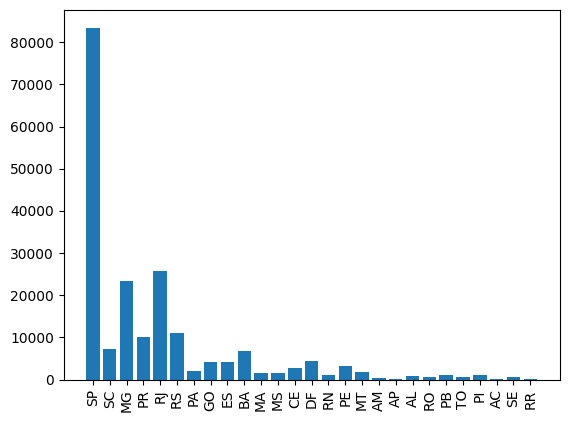

In [12]:
#Count the number of customers from each state. 
query = "select  customer_state,count(customer_unique_id) from customers group by customer_state "

cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data, columns = ["State", "Count"])
print(df)
plt.bar(df["State"],df["Count"])
plt.xticks(rotation=90)
plt.show()

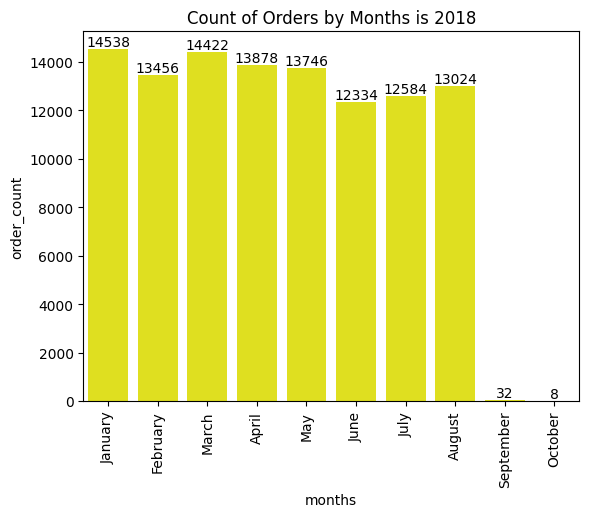

In [ ]:
#Count the number of orders in 2018
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "yellow")
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

In [17]:
#Find the average number of products per order, grouped by customer city.
try:
    while cur.nextset():
        pass
except:
    pass

query = """
WITH count_per_order AS 
(
    SELECT orders.order_id, orders.customer_id, COUNT(order_items.order_id) AS oc
    FROM orders 
    JOIN order_items
    ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)
SELECT customers.customer_city, AVG(count_per_order.oc)
FROM customers 
JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["CITY","AVERAGE"])
print(df)
df.head()

                     CITY AVERAGE
0               sao paulo  4.6249
1     sao jose dos campos  4.5539
2            porto alegre  4.6997
3                 indaial  4.4615
4            treze tilias  5.0909
...                   ...     ...
4105             sambaiba  4.0000
4106             guairaca  8.0000
4107           japaratuba  4.0000
4108               tuiuti  4.0000
4109         tibau do sul  4.0000

[4110 rows x 2 columns]


,CITY,AVERAGE
0,sao paulo,4.6249
1,sao jose dos campos,4.5539
2,porto alegre,4.6997
3,indaial,4.4615
4,treze tilias,5.0909


In [18]:
#Calculate the percentage of total revenue contributed by each product category.
query3 = """
SELECT UPPER(products.product_category) AS category, 
       (SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100 AS sales
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category
"""
cur.execute(query3)
data3 = cur.fetchall()
df = pd.DataFrame(data3, columns=["Category", "Sales"])
print(df)


                       Category      Sales
0                     PERFUMERY  12.661446
1          FURNITURE DECORATION  35.734595
2                     TELEPHONY  12.165306
3                BED TABLE BATH  42.790114
4                    AUTOMOTIVE  21.295550
..                          ...        ...
69               CDS MUSIC DVDS   0.029969
70                   LA CUISINE   0.072798
71  FASHION CHILDREN'S CLOTHING   0.019631
72                     PC GAMER   0.054331
73       INSURANCE AND SERVICES   0.008108

[74 rows x 2 columns]


In [19]:
#Identify the correlation between product price and the number of times a product has been purchased.
query ="""select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id=order_items.product_id
group by products.product_category"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Product","Count","Price"])
arr1 = df["Count"].values.astype(float)
arr2 = df["Price"].values.astype(float)

corr_matrix = np.corrcoef(arr1, arr2)
print("The correlation between roduct price and the number of times a product has been purchased is ",corr_matrix[0][1])

The correlation between roduct price and the number of times a product has been purchased is  -0.10631514167157562


In [20]:
#alculate the total revenue generated by each seller, and rank them by revenue
query = """
SELECT 
    seller_id,
    revenue,
    DENSE_RANK() OVER (ORDER BY revenue DESC) AS `rank`
FROM (
    SELECT 
        order_items.seller_id,
        SUM(payments.payment_value) AS revenue
    FROM order_items 
    JOIN payments ON order_items.order_id = payments.order_id
    GROUP BY order_items.seller_id
) AS seller_revenue
"""

cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,2.028668e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1.232888e+06,2
2,4a3ca9315b744ce9f8e9374361493884,1.204981e+06,3
3,1f50f920176fa81dab994f9023523100,1.161014e+06,4
4,53243585a1d6dc2643021fd1853d8905,1.139612e+06,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,7.684000e+01,3082
3091,702835e4b785b67a084280efca355756,7.424000e+01,3083
3092,4965a7002cca77301c82d3f91b82e1a9,6.544000e+01,3084
3093,77128dec4bec4878c37ab7d6169d6f26,6.088000e+01,3085


In [93]:
# Calculate the moving average of order values for each customer over their order history.
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df



,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


In [21]:
query = """
WITH monthly_sales AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS year,
        MONTHNAME(orders.order_purchase_timestamp) AS month,
        MONTH(orders.order_purchase_timestamp) AS month_num,
        ROUND(SUM(payments.payment_value), 2) AS monthly_payment
    FROM orders
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY year, month, month_num
)
SELECT 
    year,
    month,
    monthly_payment,
    SUM(monthly_payment) OVER (PARTITION BY year ORDER BY month_num) AS cumulative_payment
FROM monthly_sales
ORDER BY year, month_num;
"""

# Execute the query
cur.execute(query)

# Fetch the data and load into DataFrame
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", "Month", "Monthly Sales", "Cumulative Sales"])

# Display the DataFrame
print(df)



    Year      Month  Monthly Sales  Cumulative Sales
0   2016  September        1008.96           1008.96
1   2016    October      236361.92         237370.88
2   2016   December          78.48         237449.36
3   2017    January      553952.16         553952.16
4   2017   February     1167632.04        1721584.20
5   2017      March     1799454.40        3521038.60
6   2017      April     1671152.12        5192190.72
7   2017        May     2371675.28        7563866.00
8   2017       June     2045105.52        9608971.52
9   2017       July     2369531.68       11978503.20
10  2017     August     2697585.28       14676088.48
11  2017  September     2911049.80       17587138.28
12  2017    October     3118711.52       20705849.80
13  2017   November     4779531.20       25485381.00
14  2017   December     3513605.92       28998986.92
15  2018    January     4460016.72        4460016.72
16  2018   February     3969853.36        8429870.08
17  2018      March     4638608.48       13068

In [22]:
#Calculate the year-over-year growth rate of total sales.
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


In [23]:
#Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

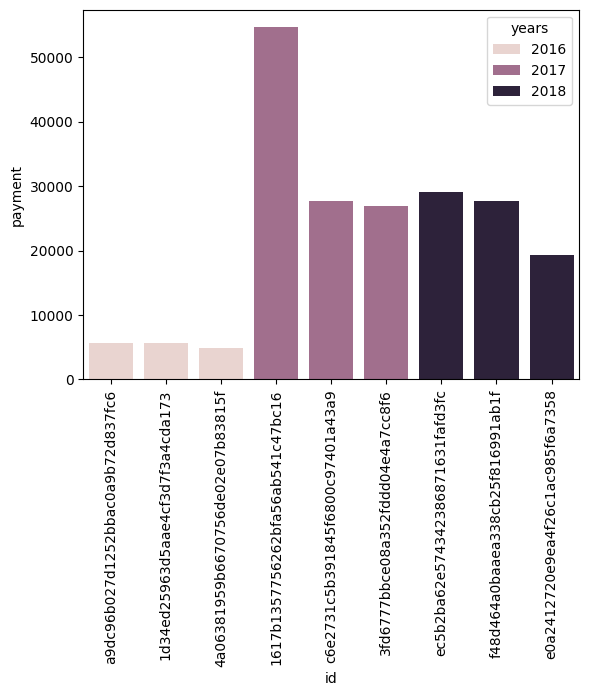

In [24]:
#Identify the top 3 customers who spent the most money in each year.
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()